In [1]:
import sys

import numpy as np
import pandas as pd

# pip install statsmodels
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

import matplotlib.pyplot as plt

sys.path.append("..")
from utils import create_onedrive_directdownload

plt.style.use("ggplot")

In [2]:
onedrive_link = "https://1drv.ms/u/s!AiqdXCxPTydhofYbhA1ASJ6RZ3OjTw?e=Kf4ZBa"
direct_use_link = create_onedrive_directdownload(onedrive_link)
print(direct_use_link)
df = pd.read_csv(direct_use_link, index_col="Month", parse_dates=True)

df.head()

https://api.onedrive.com/v1.0/shares/u!aHR0cHM6Ly8xZHJ2Lm1zL3UvcyFBaXFkWEN4UFR5ZGhvZlliaEExQVNKNlJaM09qVHc_ZT1LZjRaQmE/root/content


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
# no particular reason to choose 0.2
alpha = 0.2

In [4]:
df["EWMA"] = df["Passengers"].ewm(alpha=alpha, adjust=False).mean()

type(df["Passengers"].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

In [5]:
ses = SimpleExpSmoothing(df["Passengers"])

c:\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [6]:
# link to offset aliases docs
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [7]:
# Set the frequency
df.index.freq = 'MS'

In [8]:
ses = SimpleExpSmoothing(df["Passengers"], initialization_method='legacy-heuristic')

In [9]:
res = ses.fit(smoothing_level=alpha, optimized=False)
res

In [10]:
res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [11]:
df["SES"] = res.predict(start=df.index[0], end=df.index[-1])

In [12]:
np.allclose(df["SES"], res.fittedvalues)

True

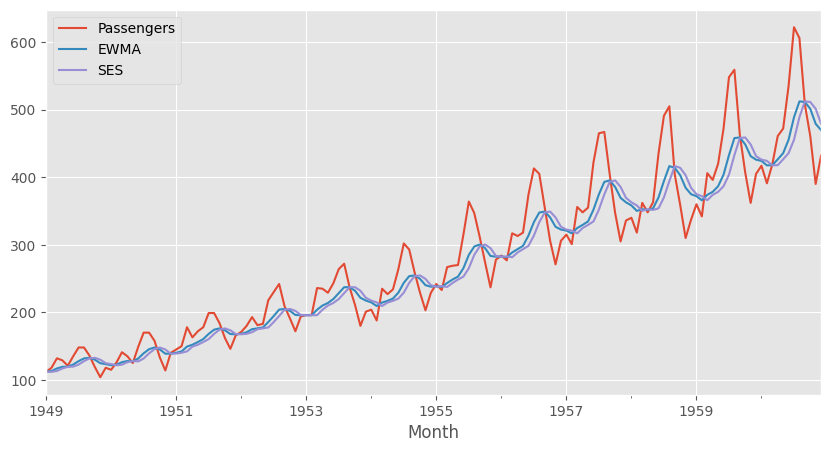

In [14]:
df.plot(figsize=(10, 5));

In [15]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


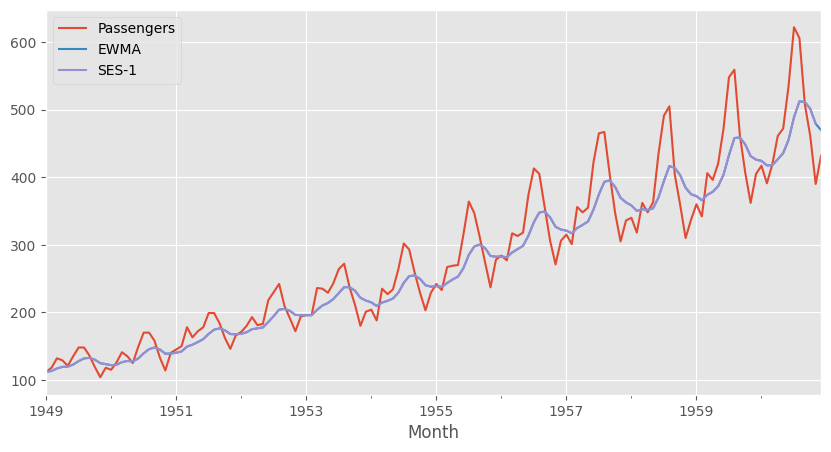

In [16]:
df["SES-1"] = df["SES"].shift(-1)

### No!
df[["Passengers", "EWMA", "SES-1"]].plot(figsize=(10, 5));

In [17]:
N_test = 12
train = df.iloc[:-N_test]
test  = df.iloc[-N_test:]

In [18]:
ses = SimpleExpSmoothing(
    train["Passengers"],
    initialization_method = "legacy-heuristic"
)

res = ses.fit()

In [19]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx  = df.index > train.index[-1]

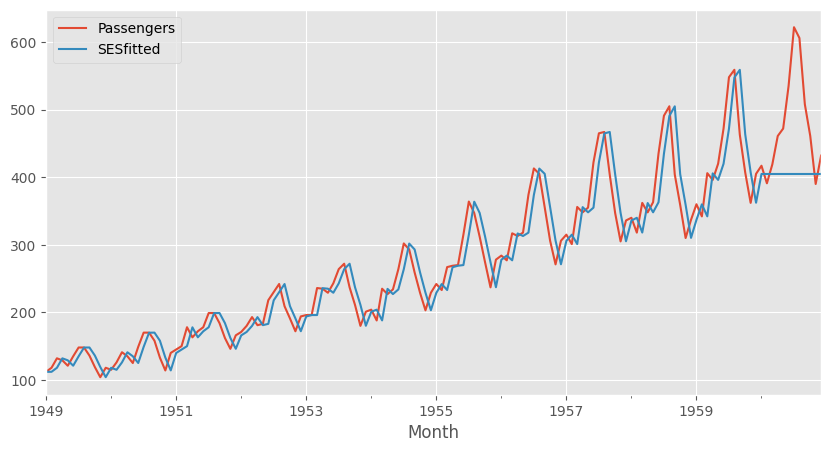

In [20]:
df.loc[train_idx, "SESfitted"] = res.fittedvalues
df.loc[test_idx, "SESfitted"] = res.forecast(N_test)
df[["Passengers", "SESfitted"]].plot(figsize=(10, 5));

In [21]:
# note the smoothing_level value, close to 1
# that's mean the model is doing the nearly naive forecast. Or in the
# other words, simply copes the last node values
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}